# Restaurant clustering playground
Run this notebook top-to-bottom. It imports helper functions from `clustering.py`. Point `DATA_PATH` to your CSV (or Excel).

In [1]:
# Install packages into THIS kernel if needed
import sys, subprocess
try:
    import sklearn, pandas, matplotlib
except Exception:
    pkgs = ["pandas", "scikit-learn", "matplotlib", "openpyxl"]
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", *pkgs])

In [2]:
import pandas as pd
from ShowClustering.clustering import (
    load_table,
    prepare_features,
    run_meanshift,
    attach_labels,
    plot_cluster_sizes,
    plot_pca_scatter_2d,
    plot_centroids_over_pca,
    DEFAULT_NUMERIC_COLS,
    DEFAULT_CATEGORICAL_COLS,
)

## 1) Point to your data

In [3]:
DATA_PATH = "data/cleaned_sales_data.csv"   # or 'Book1.xlsx'
SHEET = None               # Only used for Excel
CSV_KWARGS = {}            # e.g., {'sep': ';', 'encoding': 'utf-8-sig'}

df = load_table(DATA_PATH, sheet=SHEET, **CSV_KWARGS)
df.head()

,datetime,day_of_week,order_id,order_total,payment_method,number_of_maindishes,number_of_snacks,number_of_drinks,number_of_soups,number_of_extras,is_takeaway
0,2025-01-02 12:58:00,4,15064,327.0,1,2.0,1.0,0.0,0.0,0.0,1
1,2025-01-02 15:06:00,4,15065,287.0,2,1.0,2.0,0.0,0.0,0.0,1
2,2025-01-02 15:25:00,4,6119,685.0,3,2.0,1.0,1.0,1.0,0.0,0
3,2025-01-02 16:19:00,4,6117,109.0,3,0.0,0.0,0.0,1.0,1.0,0
4,2025-01-02 16:37:00,4,15067,129.0,1,1.0,0.0,0.0,0.0,0.0,1


## 2) Build features (ignores 'datetime' & 'order_id')

In [4]:
X, num_cols, cat_cols = prepare_features(
    df,
    numeric_cols=DEFAULT_NUMERIC_COLS,
    categorical_cols=DEFAULT_CATEGORICAL_COLS,
    ignore_cols=["datetime", "order_id"],
    force_categorical=["day_of_week", "payment_method", "is_takeaway"],
    auto_detect_categoricals=False,
    force_log1p=["order_total"],
)
print("Numeric used:", num_cols)
print("Categorical used:", cat_cols)
X.head()

Numeric used: ['order_total_log1p', 'number_of_maindishes_log1p', 'number_of_snacks', 'number_of_drinks', 'number_of_soups', 'number_of_extras']
Categorical used: ['day_of_week', 'payment_method', 'is_takeaway']


,order_total_log1p,number_of_maindishes_log1p,number_of_snacks,number_of_drinks,number_of_soups,number_of_extras,day_of_week,payment_method,is_takeaway
0,5.793014,1.098612,1.0,0.0,0.0,0.0,4,1,1
1,5.662960,0.693147,2.0,0.0,0.0,0.0,4,2,1
2,6.530878,1.098612,1.0,1.0,1.0,0.0,4,3,0
3,4.700480,0.000000,0.0,0.0,1.0,1.0,4,3,0
4,4.867534,0.693147,0.0,0.0,0.0,0.0,4,1,1


## 3) Run MeanShift

In [5]:
res = run_meanshift(
    X,
    quantiles=(0.05, 0.10, 0.15, 0.20, 0.25, 0.30),
    pca_variance=0.95,
    min_cluster_size_ratio=0.01,
    centroid_merge_eps=0.75,
)
print("Clusters:", res.n_clusters)
print("Sizes:", res.cluster_sizes)
print("Chosen quantile:", res.selected_quantile, "| bandwidth:", res.selected_bandwidth)

Clusters: 3
Sizes: [238, 126, 8586]
Chosen quantile: 0.25 | bandwidth: 2.7672294991598063


## 4) Visualize

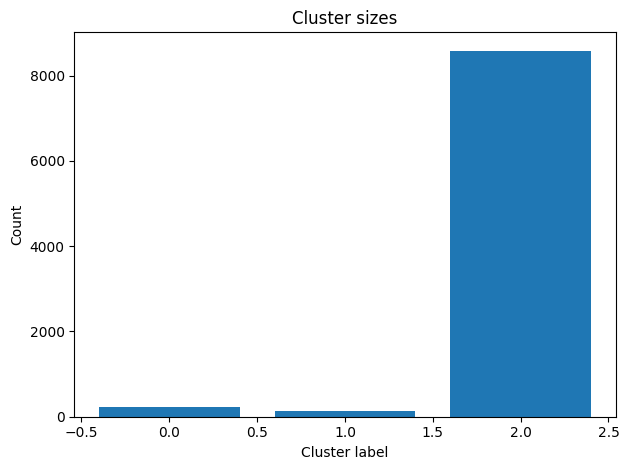

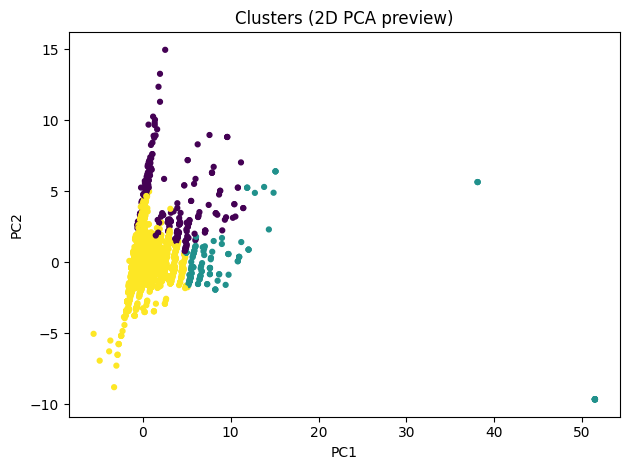

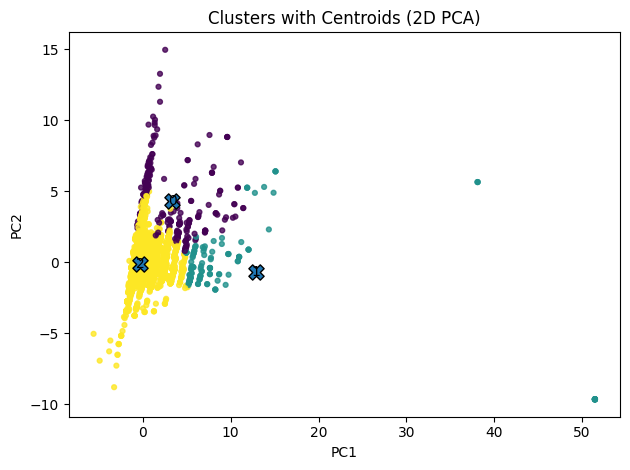

In [6]:
# Get encoded matrix before PCA for consistent 2D plots
prep = res.pipeline.named_steps['prep']
X_encoded = prep.transform(X)

plot_cluster_sizes(res.labels)
plot_pca_scatter_2d(X_encoded, res.labels, title="Clusters (2D PCA preview)")
plot_centroids_over_pca(X_encoded, res.labels, title="Clusters with Centroids (2D PCA)")

## 5) Save labeled data

In [ ]:
labeled = attach_labels(df, res.labels, column="cluster")
OUTPUT_CSV = "clustered.csv"
labeled.to_csv(OUTPUT_CSV, index=False)
labeled.head()